## FER 모델 구축하기
> FER+ 데이터셋을 먼저 시도하였으나, 라벨에 노이즈가 많아 FER 데이터셋으로 전환합니다. (Revision 2024.10.02)

kaggle에서 fer 데이터를 다운받아 압축을 해제합니다. (※ 실행 전 Kaggle API를 먼저 등록해주세요!)<br>
불필요한 파일은 압축 해제를 완료한 후 제거합니다.

In [11]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip
!mkdir data
!tar -xvzf fer2013.tar.gz -C data/
!rm challenges-in-representation-learning-facial-expression-recognition-challenge.zip example_submission.csv fer2013.tar.gz icml_face_data.csv test.csv train.csv

challenges-in-representation-learning-facial-expression-recognition-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               
fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


필요한 라이브러리를 불러옵니다.

In [35]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from collections import Counter
from IPython.display import display

pandas로 fer 데이터(fer2013.csv)을 불러와 확인합니다.

In [3]:
df = pd.read_csv('data/fer2013/fer2013.csv')

display(df.head(), df.info(), Counter(df['Usage'])) # pandas의 테이블 시각화를 여러개 띄우고 싶을 땐 display 함수를 사용

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


None

Counter({'Training': 28709, 'PublicTest': 3589, 'PrivateTest': 3589})

fer 데이터는 총 35887개 행에, 라벨인 emotion 컬럼과 48*48 이미지를 숫자화한 pixels 컬럼, 각 이미지의 용도를 구분하는 Usage 컬럼이 있는 것으로 확인됐습니다.<br><br>
먼저 emotion의 클래스를 살펴보겠습니다.

0. Angry(화남)
1. Disgust(역겨움)
2. Fear(두려움)
3. Happy(행복함)
4. Sad(슬픔)
5. Surprise(놀람)
6. Neutral(중립)

Usage의 경우, 'Training'(28709개), 'PublicTest'(3589개), 'PrivateTest'(3589개)의 세 항목으로 분류되어 있는데,<br>
편의에 따라 Train: 'Training', Validation: 'PublicTest', Test: 'PrivateTest'로 분할하여 사용하겠습니다. (비율은 8:1:1 입니다.)

(fer+는 기존 라벨에 Contempt, unknown, NF 3개 항목을 추가하여 10개로 분류하는데 이미지와 매칭되지 않는 라벨, 중복, 누락 등이 있어 사용하지 않았습니다.)

---

데이터를 본격적으로 분리하기 전에 전체 항목에 대한 각 클래스 별 분포를 먼저 확인해보겠습니다.<br>
seaborn을 이용해 emotion 컬럼에 대한 barplot을 그려줍니다.

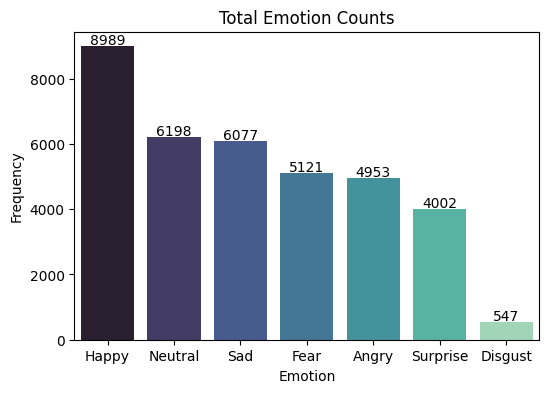

In [32]:
EMOTIONS={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

def countEmotion(df):
    cnts = df['emotion'].value_counts().reset_index()
    cnts.columns = ['emotion', 'count']
    cnts['emotion'] = cnts['emotion'].map(EMOTIONS)

    return cnts


plt.figure(figsize=(6,4))

cnts = countEmotion(df)
bar_plot = sns.barplot(x='emotion', y='count', data=cnts, palette='mako')

for index, row in cnts.iterrows():
    bar_plot.text(x=index, y=row['count']+50, s=row['count'], ha='center')

plt.title("Total Emotion Counts")
plt.xlabel("Emotion")
plt.ylabel("Frequency")
plt.show()

생각했던 것 이상으로 데이터 불균형이 심해 조금 당황스럽습니다.<br>
Disgust 클래스가 Happy 클래스 볼륨의 1/16 정도인데, 이대로 학습을 진행하게 되면 Disgust 클래스는 Underfitting이 발생할 것입니다.<br>
본격적인 학습에 들어가기 전에 데이터 증강이나 클래스 가중치를 적용하는 등의 보강법을 사용해야할 것 같습니다.

우선 Train, Validation, Test에서의 분포는 어떤지 살펴보겠습니다.

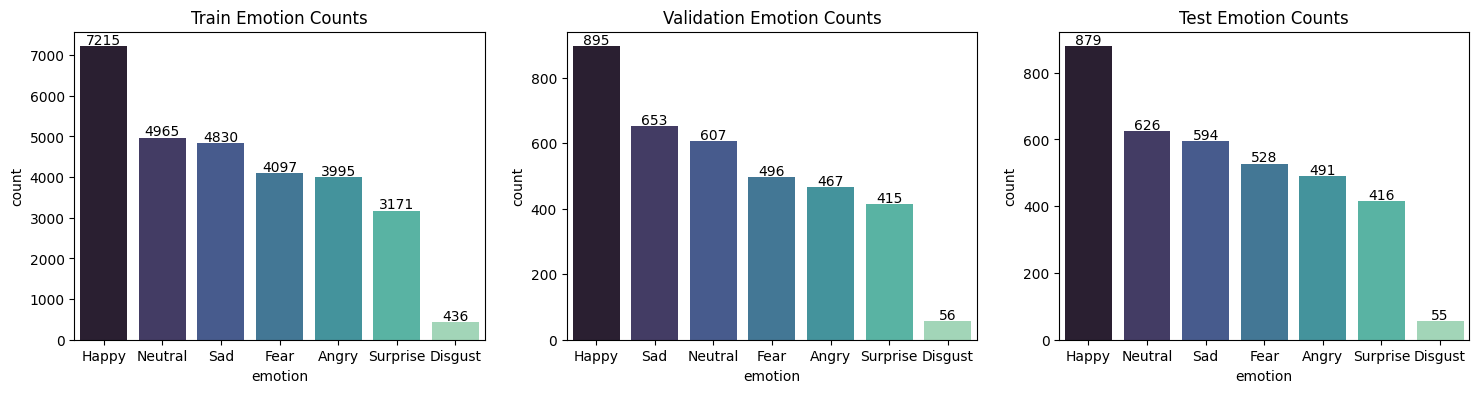

In [33]:
train_df = df[df['Usage']=='Training']
valid_df = df[df['Usage']=='PublicTest']
test_df = df[df['Usage']=='PrivateTest']

train_cnts = countEmotion(train_df)
valid_cnts = countEmotion(valid_df)
test_cnts = countEmotion(test_df)

fig, axs = plt.subplots(1, 3, figsize=(18, 4), sharey=False)

train_bar_plot = sns.barplot(x='emotion', y='count', data=train_cnts, palette='mako', ax=axs[0])
valid_bar_plot = sns.barplot(x='emotion', y='count', data=valid_cnts, palette='mako', ax=axs[1])
test_bar_plot = sns.barplot(x='emotion', y='count', data=test_cnts, palette='mako', ax=axs[2])

for index, row in train_cnts.iterrows():
    train_bar_plot.text(x=index, y=row['count']+50, s=row['count'], ha='center')

for index, row in valid_cnts.iterrows():
    valid_bar_plot.text(x=index, y=row['count']+5, s=row['count'], ha='center')

for index, row in test_cnts.iterrows():
    test_bar_plot.text(x=index, y=row['count']+5, s=row['count'], ha='center')

axs[0].set_title("Train Emotion Counts")
axs[1].set_title("Validation Emotion Counts")
axs[2].set_title("Test Emotion Counts")

plt.show()

이걸 다행이라고 봐야하는지는 모르겠지만 적은 양의 Disgust 클래스를 각 데이터셋에 고르게 분배해주긴 했습니다.<br>
클래스 가중치 적용 학습을 먼저 시도해보고, 성능이 기대치 이하일 경우 데이터 증강을 노려봐야겠습니다.